In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

## Data Summary

In [2]:
df = pd.read_csv("amazon_delivery.csv")

In [3]:
df.head()

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys


In [4]:
df.shape

(43739, 16)

This has 43739 observations and 16 columns. <br>
The delivery time is a potential target variable

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.3+ MB


There are 9 categorical variables and 7 numerical variables

## Objective Of The Analysis

In this Analysis, we are keeping delivery time as the target variable, and using other features like agent age, mode of delivery, delivery time, we are aiming to predict the delivery time

For this analysis:
 - Order Id is irrelevant, so we will be removing it.
 - combine the four features: store latitude, store longitude, drop latitude, drop longitude to a single feature called distance.
 - transform and split the date column to day of the week column and month column.

## Data Cleaning

Handling missing values

In [6]:
for column in df.columns:
    if df[column].isna().sum() > 0:
        print(column)


Agent_Rating
Weather


So only 2 columns, Agent_Rating and Weather have null data

In [7]:
df["Agent_Rating"].isna().sum()

np.int64(54)

In [8]:
df["Weather"].isna().sum()

np.int64(91)

In [9]:
df[df["Weather"].isna() & df["Agent_Rating"].isna()]

,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category


So, there is no overlap, and in total there are 145 records with missing value, since this contributes only 0.33% of our total dataset, we can drop it

In [10]:
df.dropna(inplace = True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43594 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43594 non-null  object 
 1   Agent_Age        43594 non-null  int64  
 2   Agent_Rating     43594 non-null  float64
 3   Store_Latitude   43594 non-null  float64
 4   Store_Longitude  43594 non-null  float64
 5   Drop_Latitude    43594 non-null  float64
 6   Drop_Longitude   43594 non-null  float64
 7   Order_Date       43594 non-null  object 
 8   Order_Time       43594 non-null  object 
 9   Pickup_Time      43594 non-null  object 
 10  Weather          43594 non-null  object 
 11  Traffic          43594 non-null  object 
 12  Vehicle          43594 non-null  object 
 13  Area             43594 non-null  object 
 14  Delivery_Time    43594 non-null  int64  
 15  Category         43594 non-null  object 
dtypes: float64(5), int64(2), object(9)
memory usage: 5.7+ MB


Handling Duplicates

In [12]:
df.duplicated().sum()

np.int64(0)

There are no duplicate records

Column Transformations

In [13]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in km
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    a = math.sin(delta_phi / 2)**2 + \
        math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c  # in kilometers
    return distance

df["Distance"] = df.apply(lambda row: haversine(row['Store_Latitude'], row['Store_Longitude'], row['Drop_Latitude'], row['Drop_Longitude']), axis=1)

In [14]:
df.drop(columns = ['Store_Latitude', 'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude'], axis = 1, inplace = True)

In [15]:
df.drop(columns = ['Order_ID'], axis = 1, inplace = True)

In [16]:
df["Order_Day"] = pd.to_datetime(df["Order_Date"]).dt.dayofweek
df["Order_Month"] = pd.to_datetime(df["Order_Date"]).dt.month_name()

In [17]:
df.drop(columns = ["Order_Date"], inplace = True)

In [18]:
df.head()

,Agent_Age,Agent_Rating,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance,Order_Day,Order_Month
0,37,4.9,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing,3.025149,5,March
1,34,4.5,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics,20.183530,4,March
2,23,4.4,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports,1.552758,5,March
3,38,4.7,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics,7.790401,1,April
4,32,4.6,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys,6.210138,5,March


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43594 entries, 0 to 43738
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Agent_Age      43594 non-null  int64  
 1   Agent_Rating   43594 non-null  float64
 2   Order_Time     43594 non-null  object 
 3   Pickup_Time    43594 non-null  object 
 4   Weather        43594 non-null  object 
 5   Traffic        43594 non-null  object 
 6   Vehicle        43594 non-null  object 
 7   Area           43594 non-null  object 
 8   Delivery_Time  43594 non-null  int64  
 9   Category       43594 non-null  object 
 10  Distance       43594 non-null  float64
 11  Order_Day      43594 non-null  int32  
 12  Order_Month    43594 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(8)
memory usage: 4.5+ MB


Handling Outliers

In [20]:
numeric_cols = df.select_dtypes(include = ["int64","float64","int32"])
numeric_cols.columns

Index(['Agent_Age', 'Agent_Rating', 'Delivery_Time', 'Distance', 'Order_Day'], dtype='object')

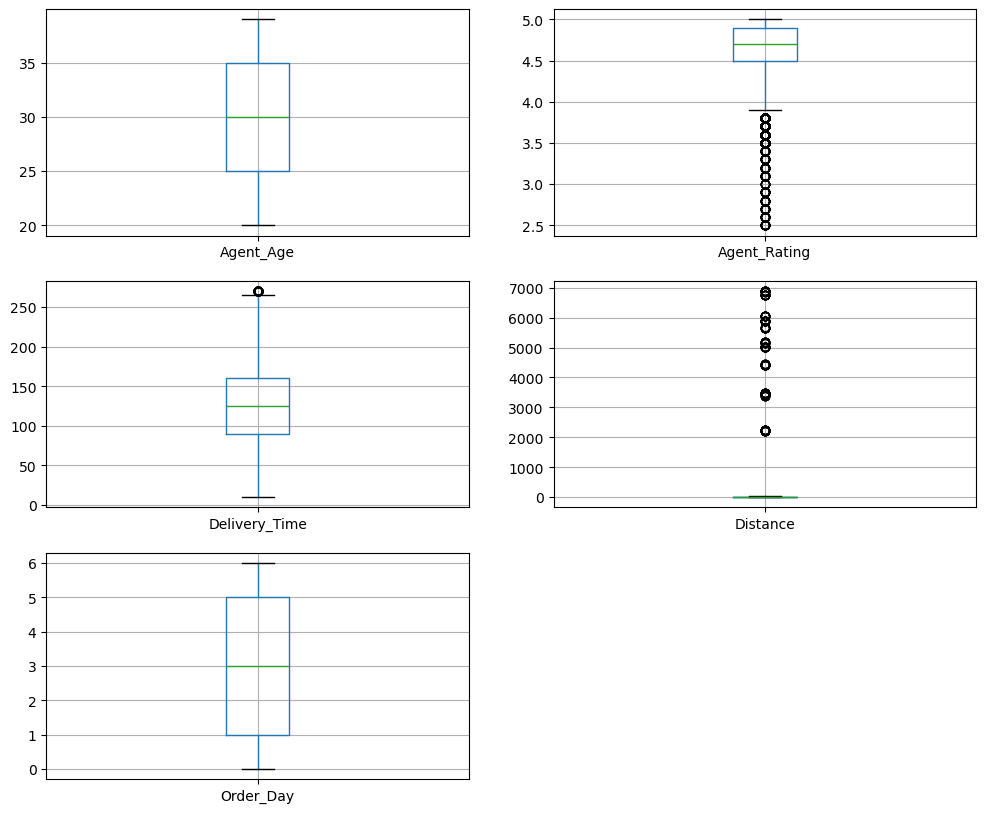

In [21]:
plt.figure(figsize=(12, 10))
for i,col in enumerate(numeric_cols):
    plt.subplot(3,2,i+1)
    df[[col]].boxplot()
plt.show()

In [22]:
df[df["Distance"] > 2000].count()

Agent_Age        151
Agent_Rating     151
Order_Time       151
Pickup_Time      151
Weather          151
Traffic          151
Vehicle          151
Area             151
Delivery_Time    151
Category         151
Distance         151
Order_Day        151
Order_Month      151
dtype: int64

We are only going to handle distance outliers, rest should be fine, because it is normal to give bad ratings for delivery agent

In [23]:
Q1 = np.percentile(df["Distance"],25)
Q3 = np.percentile(df["Distance"],75)
IQR = Q3 - Q1
mini = Q1 - 1.5*IQR
maxi = Q3 + 1.5*IQR
mask = (df["Distance"] < mini) | (df["Distance"] > maxi)
df[mask].index

Index([   90,   275,  1045,  1705,  1893,  2015,  2052,  2112,  2202,  2526,
       ...
       38890, 38917, 39476, 39927, 41869, 42071, 42252, 42824, 43105, 43343],
      dtype='int64', length=151)

In [24]:
df.drop(index = df[mask].index, inplace = True)

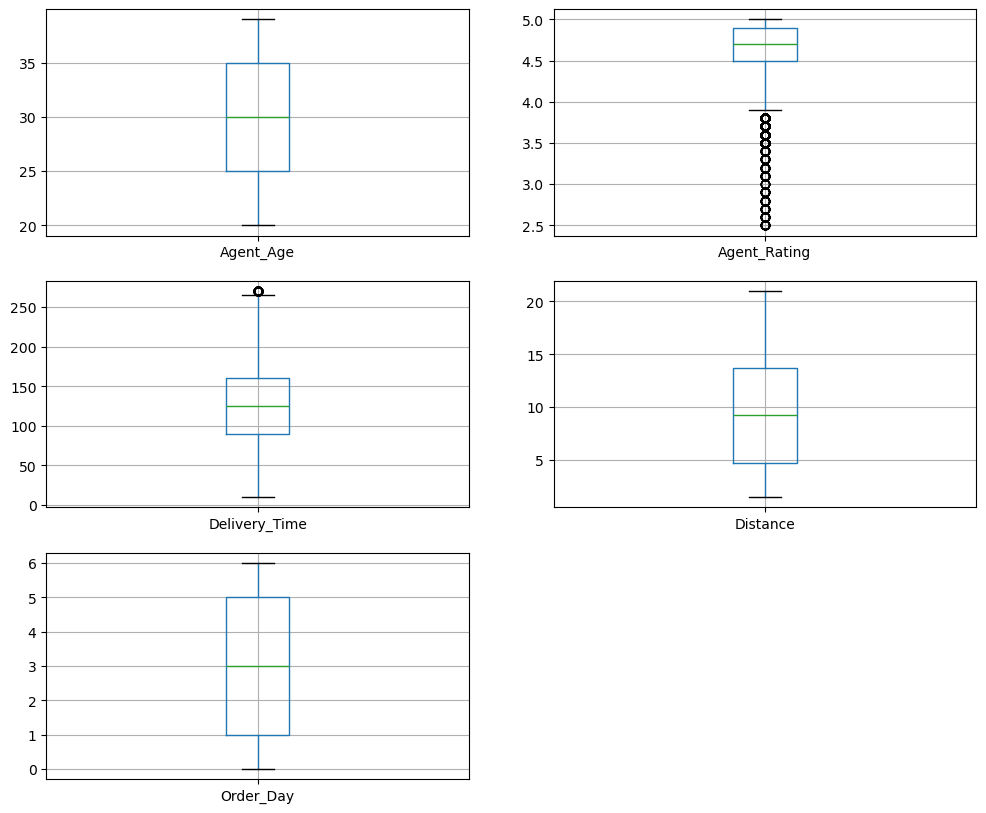

In [25]:
plt.figure(figsize=(12, 10))
for i,col in enumerate(numeric_cols):
    plt.subplot(3,2,i+1)
    df[[col]].boxplot()
plt.show()

Handling typos

In [26]:
df["Weather"].value_counts()

Weather
Fog           7412
Stormy        7344
Cloudy        7253
Sandstorms    7209
Windy         7187
Sunny         7038
Name: count, dtype: int64

In [27]:
df["Traffic"].value_counts()

Traffic
Low        14918
Jam        13664
Medium     10584
High        4277
Name: count, dtype: int64

In [28]:
df["Vehicle"].value_counts()

Vehicle
motorcycle     25394
scooter        14545
van             3504
Name: count, dtype: int64

In [29]:
df["Area"].value_counts()

Area
Metropolitian     32483
Urban              9676
Other              1132
Semi-Urban          152
Name: count, dtype: int64

In [30]:
df["Category"].value_counts()

Category
Electronics     2833
Books           2801
Jewelry         2785
Toys            2761
Skincare        2758
Snacks          2752
Outdoors        2733
Apparel         2710
Sports          2695
Grocery         2678
Pet Supplies    2670
Home            2664
Cosmetics       2659
Kitchen         2654
Clothing        2648
Shoes           2642
Name: count, dtype: int64

No typos found

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43443 entries, 0 to 43738
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Agent_Age      43443 non-null  int64  
 1   Agent_Rating   43443 non-null  float64
 2   Order_Time     43443 non-null  object 
 3   Pickup_Time    43443 non-null  object 
 4   Weather        43443 non-null  object 
 5   Traffic        43443 non-null  object 
 6   Vehicle        43443 non-null  object 
 7   Area           43443 non-null  object 
 8   Delivery_Time  43443 non-null  int64  
 9   Category       43443 non-null  object 
 10  Distance       43443 non-null  float64
 11  Order_Day      43443 non-null  int32  
 12  Order_Month    43443 non-null  object 
dtypes: float64(2), int32(1), int64(2), object(8)
memory usage: 4.5+ MB


## Variable Transformations

In [32]:
all_cols = set(df.columns)
numeric_cols = set(df.select_dtypes(include = ["int64","int32","float64"]).columns)
categorical_cols = all_cols - numeric_cols
categorical_cols

{'Area',
 'Category',
 'Order_Month',
 'Order_Time',
 'Pickup_Time',
 'Traffic',
 'Vehicle',
 'Weather'}

In [33]:
numeric_cols

{'Agent_Age', 'Agent_Rating', 'Delivery_Time', 'Distance', 'Order_Day'}

In [34]:
cols_to_be_transformed = list(categorical_cols)

In [35]:
df[cols_to_be_transformed].head()

,Weather,Order_Month,Area,Order_Time,Vehicle,Traffic,Category,Pickup_Time
0,Sunny,March,Urban,11:30:00,motorcycle,High,Clothing,11:45:00
1,Stormy,March,Metropolitian,19:45:00,scooter,Jam,Electronics,19:50:00
2,Sandstorms,March,Urban,08:30:00,motorcycle,Low,Sports,08:45:00
3,Sunny,April,Metropolitian,18:00:00,motorcycle,Medium,Cosmetics,18:10:00
4,Cloudy,March,Metropolitian,13:30:00,scooter,High,Toys,13:45:00


In [36]:
df["Weather"].value_counts()

Weather
Fog           7412
Stormy        7344
Cloudy        7253
Sandstorms    7209
Windy         7187
Sunny         7038
Name: count, dtype: int64

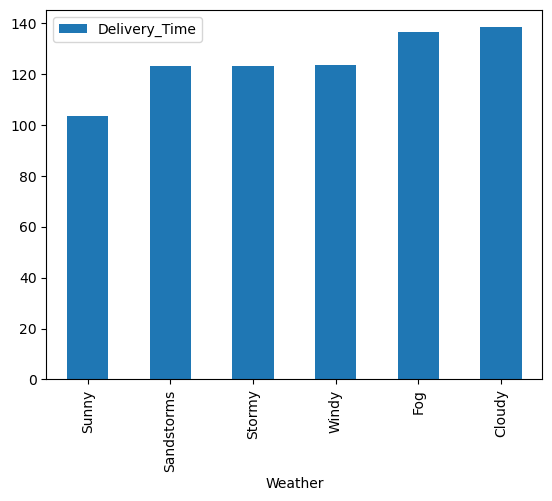

In [37]:
df.groupby("Weather")["Delivery_Time"].mean().to_frame().sort_values(by = "Delivery_Time").plot(kind = "bar")
plt.show()

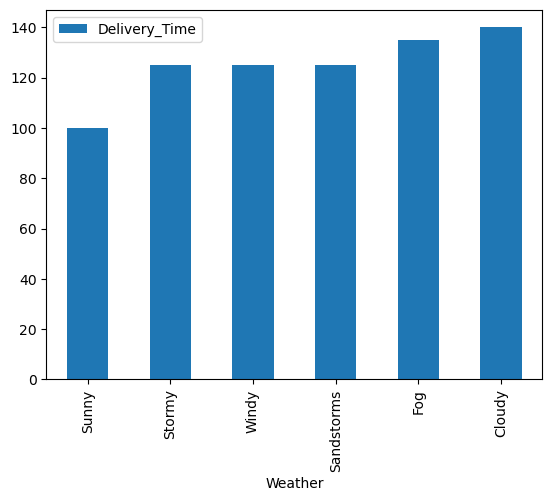

In [38]:
df.groupby("Weather")["Delivery_Time"].median().to_frame().sort_values(by = "Delivery_Time").plot(kind = "bar")
plt.show()

I am ordering weather in the increasing order for diffuclty to commute: ["Sunny","Sandstorms","Stormy","Windy","Fog","Cloudy"] <br>
Sunny -> 1 <br>
Sandstorms,Stormy,Windy -> 2 <br>
Fog, Cloudy -> 3 <br>

In [40]:
df["Weather"] = df["Weather"].replace({
    "Sunny": 1,
    "Stormy": 2,
    "Sandstorms": 2,
    "Windy": 2,
    "Fog": 3,
    "Cloudy": 3
})
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


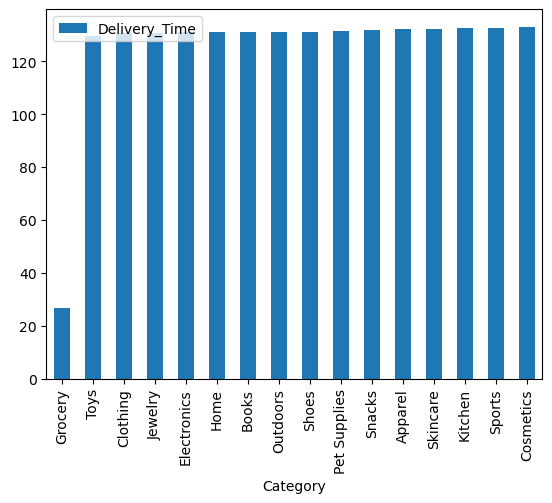

In [41]:
df.groupby("Category")["Delivery_Time"].mean().to_frame().sort_values(by = "Delivery_Time").plot(kind = "bar")
plt.show()

In [42]:
df.Category.value_counts()

Category
Electronics     2833
Books           2801
Jewelry         2785
Toys            2761
Skincare        2758
Snacks          2752
Outdoors        2733
Apparel         2710
Sports          2695
Grocery         2678
Pet Supplies    2670
Home            2664
Cosmetics       2659
Kitchen         2654
Clothing        2648
Shoes           2642
Name: count, dtype: int64

Here except for Grocery, all other categories take similar time, so I am categorizing it as grocery and non-grocery 

In [43]:
df["Category"] = np.where(df["Category"] == "Grocery", 0, 1)

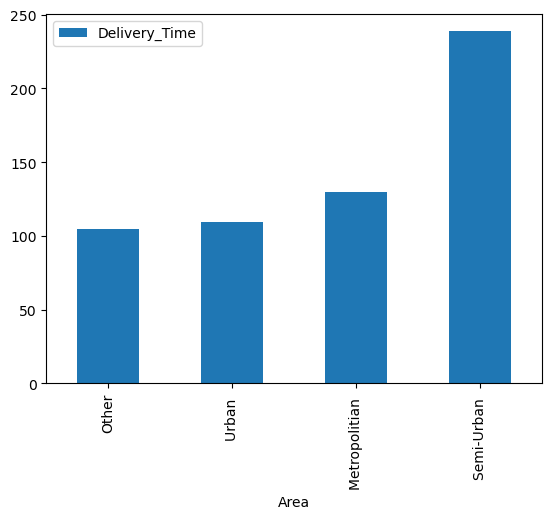

In [44]:
df.groupby("Area")["Delivery_Time"].mean().to_frame().sort_values(by = "Delivery_Time").plot(kind = "bar")
plt.show()

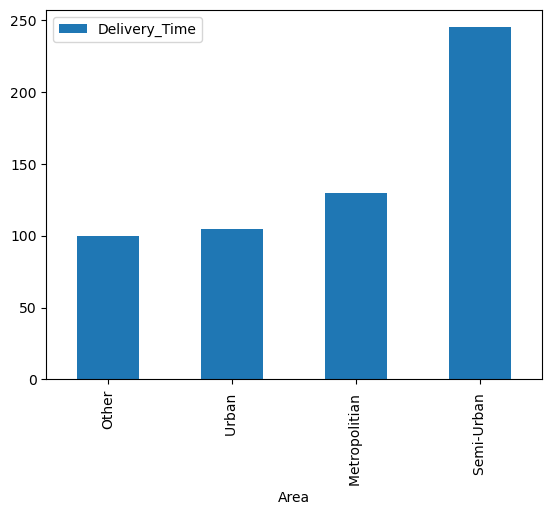

In [45]:
df.groupby("Area")["Delivery_Time"].median().to_frame().sort_values(by = "Delivery_Time").plot(kind = "bar")
plt.show()

In [46]:
df.Area.value_counts()

Area
Metropolitian     32483
Urban              9676
Other              1132
Semi-Urban          152
Name: count, dtype: int64

In [47]:
df.Area.unique().tolist()

['Urban ', 'Metropolitian ', 'Semi-Urban ', 'Other']

In [48]:
df["Area"] = np.where(df["Area"] == "Semi-Urban ",1,0)


In [49]:
df.Area.value_counts()

Area
0    43291
1      152
Name: count, dtype: int64

In [50]:
df.groupby("Traffic")["Delivery_Time"].mean().to_frame().sort_values(by = "Delivery_Time")

,Delivery_Time
Traffic,
Low,101.365129
Medium,126.850151
High,129.426935
Jam,147.779567


In [51]:
df.Traffic = df.Traffic.str.strip()

In [52]:
df.Traffic.unique().tolist()

['High', 'Jam', 'Low', 'Medium']

In [53]:
df.Traffic.value_counts()

Traffic
Low       14918
Jam       13664
Medium    10584
High       4277
Name: count, dtype: int64

In [54]:
oe = OrdinalEncoder(categories = [["Low",'Medium','High','Jam']])

df["Traffic"] = pd.Series(
    oe.fit_transform(df[["Traffic"]]).flatten(),
    index=df.index
)


In [55]:
df.head()

,Agent_Age,Agent_Rating,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance,Order_Day,Order_Month
0,37,4.9,11:30:00,11:45:00,1,2.0,motorcycle,0,120,1,3.025149,5,March
1,34,4.5,19:45:00,19:50:00,2,3.0,scooter,0,165,1,20.183530,4,March
2,23,4.4,08:30:00,08:45:00,2,0.0,motorcycle,0,130,1,1.552758,5,March
3,38,4.7,18:00:00,18:10:00,1,1.0,motorcycle,0,105,1,7.790401,1,April
4,32,4.6,13:30:00,13:45:00,3,2.0,scooter,0,150,1,6.210138,5,March


In [56]:
df.groupby("Vehicle")["Delivery_Time"].mean().to_frame().sort_values(by = "Delivery_Time")

,Delivery_Time
Vehicle,
van,116.235731
scooter,116.362599
motorcycle,131.045995


In [57]:
df["Vehicle"] = df["Vehicle"].str.strip()
df["Vehicle"].unique().tolist()

['motorcycle', 'scooter', 'van']

In [58]:
df["Vehicle"] = np.where(df["Vehicle"] == 'motorcycle',1,0)

In [59]:
df.head()

,Agent_Age,Agent_Rating,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance,Order_Day,Order_Month
0,37,4.9,11:30:00,11:45:00,1,2.0,1,0,120,1,3.025149,5,March
1,34,4.5,19:45:00,19:50:00,2,3.0,0,0,165,1,20.183530,4,March
2,23,4.4,08:30:00,08:45:00,2,0.0,1,0,130,1,1.552758,5,March
3,38,4.7,18:00:00,18:10:00,1,1.0,1,0,105,1,7.790401,1,April
4,32,4.6,13:30:00,13:45:00,3,2.0,0,0,150,1,6.210138,5,March


In [60]:
df["Order_Time"] = pd.to_datetime(df["Order_Time"], format="%H:%M:%S").dt.time
def get_time_of_day(t):
    hour = t.hour
    if 5 <= hour < 12:
        return "morning"
    elif 12 <= hour < 17:
        return "afternoon"
    elif 17 <= hour < 21:
        return "evening"
    else:
        return "night"
df["Order_Time"] = df["Order_Time"].apply(get_time_of_day)
df = pd.get_dummies(df, columns=["Order_Time"])


In [61]:
df["Pickup_Time"] = pd.to_datetime(df["Pickup_Time"], format="%H:%M:%S").dt.time
def get_time_of_day(t):
    hour = t.hour
    if 5 <= hour < 12:
        return "morning"
    elif 12 <= hour < 17:
        return "afternoon"
    elif 17 <= hour < 21:
        return "evening"
    else:
        return "night"
df["Pickup_Time"] = df["Pickup_Time"].apply(get_time_of_day)
df = pd.get_dummies(df, columns=["Pickup_Time"])

In [62]:
df.replace({False : 0, True : 1}, inplace = True)

In [63]:
df.head()

,Agent_Age,Agent_Rating,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance,Order_Day,Order_Month,Order_Time_afternoon,Order_Time_evening,Order_Time_morning,Order_Time_night,Pickup_Time_afternoon,Pickup_Time_evening,Pickup_Time_morning,Pickup_Time_night
0,37,4.9,1,2.0,1,0,120,1,3.025149,5,March,0,0,1,0,0,0,1,0
1,34,4.5,2,3.0,0,0,165,1,20.183530,4,March,0,1,0,0,0,1,0,0
2,23,4.4,2,0.0,1,0,130,1,1.552758,5,March,0,0,1,0,0,0,1,0
3,38,4.7,1,1.0,1,0,105,1,7.790401,1,April,0,1,0,0,0,1,0,0
4,32,4.6,3,2.0,0,0,150,1,6.210138,5,March,1,0,0,0,1,0,0,0


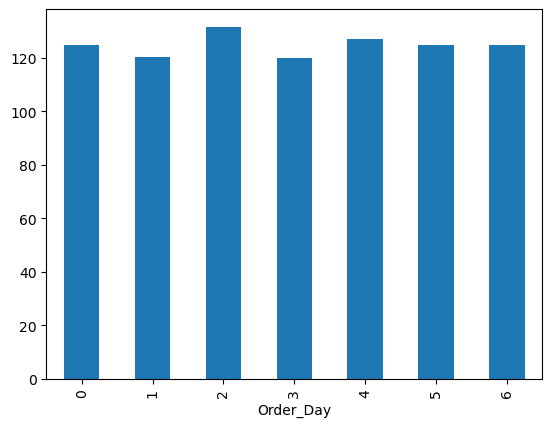

In [64]:
df.groupby("Order_Day")["Delivery_Time"].mean().plot(kind = "bar")
plt.show()

In [65]:
df[["Order_Day","Delivery_Time"]].corr()

,Order_Day,Delivery_Time
Order_Day,1.000000,0.006004
Delivery_Time,0.006004,1.000000


not much correlation between order_day and delivery_time, so we can remove the feature

In [66]:
df.drop(columns = {"Order_Day"},inplace=True)
df.head()

,Agent_Age,Agent_Rating,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance,Order_Month,Order_Time_afternoon,Order_Time_evening,Order_Time_morning,Order_Time_night,Pickup_Time_afternoon,Pickup_Time_evening,Pickup_Time_morning,Pickup_Time_night
0,37,4.9,1,2.0,1,0,120,1,3.025149,March,0,0,1,0,0,0,1,0
1,34,4.5,2,3.0,0,0,165,1,20.183530,March,0,1,0,0,0,1,0,0
2,23,4.4,2,0.0,1,0,130,1,1.552758,March,0,0,1,0,0,0,1,0
3,38,4.7,1,1.0,1,0,105,1,7.790401,April,0,1,0,0,0,1,0,0
4,32,4.6,3,2.0,0,0,150,1,6.210138,March,1,0,0,0,1,0,0,0


In [67]:
df.groupby("Order_Month")["Delivery_Time"].count()

Order_Month
April        6090
February     6765
March       30588
Name: Delivery_Time, dtype: int64

In [68]:
df = pd.get_dummies(df, columns=["Order_Month"])
df.head()

,Agent_Age,Agent_Rating,Weather,Traffic,Vehicle,Area,Delivery_Time,Category,Distance,Order_Time_afternoon,Order_Time_evening,Order_Time_morning,Order_Time_night,Pickup_Time_afternoon,Pickup_Time_evening,Pickup_Time_morning,Pickup_Time_night,Order_Month_April,Order_Month_February,Order_Month_March
0,37,4.9,1,2.0,1,0,120,1,3.025149,0,0,1,0,0,0,1,0,False,False,True
1,34,4.5,2,3.0,0,0,165,1,20.183530,0,1,0,0,0,1,0,0,False,False,True
2,23,4.4,2,0.0,1,0,130,1,1.552758,0,0,1,0,0,0,1,0,False,False,True
3,38,4.7,1,1.0,1,0,105,1,7.790401,0,1,0,0,0,1,0,0,True,False,False
4,32,4.6,3,2.0,0,0,150,1,6.210138,1,0,0,0,1,0,0,0,False,False,True


In [69]:
df.replace({False : 0, True : 1}, inplace = True)

In [70]:
df.isna().sum()

Agent_Age                0
Agent_Rating             0
Weather                  0
Traffic                  0
Vehicle                  0
Area                     0
Delivery_Time            0
Category                 0
Distance                 0
Order_Time_afternoon     0
Order_Time_evening       0
Order_Time_morning       0
Order_Time_night         0
Pickup_Time_afternoon    0
Pickup_Time_evening      0
Pickup_Time_morning      0
Pickup_Time_night        0
Order_Month_April        0
Order_Month_February     0
Order_Month_March        0
dtype: int64

## Model Comparisons

Linear Regression

In [71]:
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In [72]:
x = df.drop("Delivery_Time",axis = 1)
y = df.Delivery_Time
ss = StandardScaler()
x = pd.DataFrame(ss.fit_transform(x))

In [73]:
train_x,test_x,train_y,test_y = train_test_split(x,y,test_size = 0.3, random_state = 42)

Linear Regression with Polynomial Features

In [74]:
lr = LinearRegression()
lr.fit(train_x,train_y)
pred_y = lr.predict(test_x)
r2_score(pred_y,test_y)

0.3467584442463427

In [75]:
lasso = Lasso(alpha = 0.1, max_iter = 100000)
lasso.fit(train_x,train_y)
pred_y = lasso.predict(test_x)
r2_score(pred_y,test_y)

0.3380515981006167

This means the model is too simple

In [76]:
poly = PolynomialFeatures(degree = 3)
new_x = poly.fit_transform(x)
train_x,test_x,train_y,test_y = train_test_split(new_x,y,test_size = 0.3, random_state = 42)

In [77]:
lr = LinearRegression()
lr.fit(train_x,train_y)
pred_y = lr.predict(test_x)
r2_score(pred_y,test_y)

0.6560644189077084

## Conclusion

Order Date and Time are the most important features

## Flaws and next step

The model is too simple, the next steps will be to add more features, and find more complex relations, but currently my laptop is not supporting polynomial features of degree more than 3, I observed as we make the model more complex, the r2_score seemed to improve